<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multiple-Linear-Regression" data-toc-modified-id="Multiple-Linear-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multiple Linear Regression</a></span></li><li><span><a href="#Objectives" data-toc-modified-id="Objectives-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Objectives</a></span></li><li><span><a href="#Regression-with-Multiple-Predictors" data-toc-modified-id="Regression-with-Multiple-Predictors-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Regression with Multiple Predictors</a></span><ul class="toc-item"><li><span><a href="#Expanding-Simple-Linear-Regression" data-toc-modified-id="Expanding-Simple-Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Expanding Simple Linear Regression</a></span></li><li><span><a href="#Closed-form-Solution" data-toc-modified-id="Closed-form-Solution-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Closed-form Solution</a></span></li></ul></li><li><span><a href="#Confounding-Variables" data-toc-modified-id="Confounding-Variables-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Confounding Variables</a></span></li><li><span><a href="#Dealing-with-Categorical-Variables" data-toc-modified-id="Dealing-with-Categorical-Variables-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Dealing with Categorical Variables</a></span><ul class="toc-item"><li><span><a href="#Dummying" data-toc-modified-id="Dummying-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Dummying</a></span></li></ul></li><li><span><a href="#Multiple-Regression-in-statsmodels" data-toc-modified-id="Multiple-Regression-in-statsmodels-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Multiple Regression in <code>statsmodels</code></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Diamonds-Dataset" data-toc-modified-id="Diamonds-Dataset-6.0.1"><span class="toc-item-num">6.0.1&nbsp;&nbsp;</span>Diamonds Dataset</a></span></li><li><span><a href="#Check-distribution-of-target" data-toc-modified-id="Check-distribution-of-target-6.0.2"><span class="toc-item-num">6.0.2&nbsp;&nbsp;</span>Check distribution of target</a></span></li><li><span><a href="#Build-model-with-log-scaled-target" data-toc-modified-id="Build-model-with-log-scaled-target-6.0.3"><span class="toc-item-num">6.0.3&nbsp;&nbsp;</span>Build model with log-scaled target</a></span></li></ul></li></ul></li><li><span><a href="#Putting-it-in-Practice:-Wine-Dataset-🍷" data-toc-modified-id="Putting-it-in-Practice:-Wine-Dataset-🍷-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Putting it in Practice: Wine Dataset 🍷</a></span><ul class="toc-item"><li><span><a href="#The-Wine-Dataset" data-toc-modified-id="The-Wine-Dataset-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>The Wine Dataset</a></span><ul class="toc-item"><li><span><a href="#🧠-Knowledge-Check" data-toc-modified-id="🧠-Knowledge-Check-7.1.1"><span class="toc-item-num">7.1.1&nbsp;&nbsp;</span>🧠 <strong>Knowledge Check</strong></a></span></li><li><span><a href="#Running-the-Regression" data-toc-modified-id="Running-the-Regression-7.1.2"><span class="toc-item-num">7.1.2&nbsp;&nbsp;</span>Running the Regression</a></span></li></ul></li></ul></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Scaling</a></span></li><li><span><a href="#Multiple-Regression-in-Scikit-Learn" data-toc-modified-id="Multiple-Regression-in-Scikit-Learn-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Multiple Regression in Scikit-Learn</a></span><ul class="toc-item"><li><span><a href="#Sklearn-Metrics" data-toc-modified-id="Sklearn-Metrics-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Sklearn Metrics</a></span></li></ul></li><li><span><a href="#Level-Up:-Regression-with-Categorical-Features-with-the-Comma-Dataset" data-toc-modified-id="Level-Up:-Regression-with-Categorical-Features-with-the-Comma-Dataset-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Level Up: Regression with Categorical Features with the Comma Dataset</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats

%matplotlib inline

![mlr](https://miro.medium.com/max/1280/1*lJKFo3yyZaFIx4ET1dLmlg.png)

# Multiple Linear Regression

# Objectives

- Conduct linear regressions in `statsmodels` and in `sklearn`
- Use the one-hot strategy to encode categorical variables

# Regression with Multiple Predictors

> It's all a bunch of dials

<img width='450px' src='img/dials.png'/>

The main idea here is pretty simple. Whereas, in simple linear regression we took our dependent variable to be a function only of a single independent variable, here we'll be taking the dependent variable to be a function of multiple independent variables.

## Expanding Simple Linear Regression

Our regression equation, then, instead of looking like $\hat{y} = mx + b$, will now look like:

$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1x_1 + ... + \hat{\beta}_nx_n$.

Remember that the hats ( $\hat{}$ ) indicate parameters that are estimated.

Is this still a best-fit *line*? Well, no. What does the graph of, say, z = x + y look like? [Here's](https://academo.org/demos/3d-surface-plotter/) a 3d-plotter. (Of course, once we get x's with subscripts beyond 2 it's going to be very hard to visualize. But in practice linear regressions can make use of dozens or even of hundreds of independent variables!)

## Closed-form Solution

Is it possible to calculate the betas by hand? Yes, a multiple regression problem still has a closed-form solution.

In a word, for a multiple linear regression problem where $X$ is the matrix of independent variable values and $y$ is the vector of dependent variable values, the vector of optimizing regression coefficients $\vec{b}$ is given by:

$\vec{b} = (X^TX)^{-1}X^Ty$.

We'll focus more directly on matrix mathematics later in the course, so don't worry if this equation is opaque to you. See [here](https://stattrek.com/multiple-regression/regression-coefficients.aspx) for a nice explanation and example.

# Confounding Variables

Suppose I have a simple linear regression that models the growth of corn plants as a function of the temperature of the ambient air. And suppose there is a noticeable positive correlation between temperature and plant height.

In [2]:
corn = pd.read_csv('data/corn.csv',
                  usecols=['temp', 'humid', 'height'])

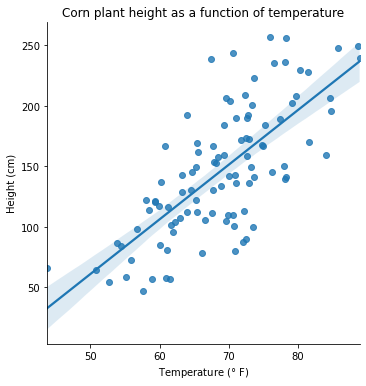

In [3]:
sns.lmplot(data=corn, x='temp', y='height')
plt.xlabel('Temperature ($\degree$ F)')
plt.ylabel('Height (cm)')
plt.title('Corn plant height as a function of temperature');

In [4]:
corn.head()

,temp,humid,height
0,58.086965,49.848304,122.222368
1,70.582087,22.855446,110.079666
2,75.868571,72.856834,256.812528
3,74.732376,38.907566,167.889601
4,77.384666,42.570524,188.914312


It seems that higher temperatures lead to taller corn plants. But it's hard to know for sure. One **confounding variable** might be *humidity*. If we haven't controlled for humidity, then it's difficult to draw conclusions.

One solution is to use **both features** in a single model.

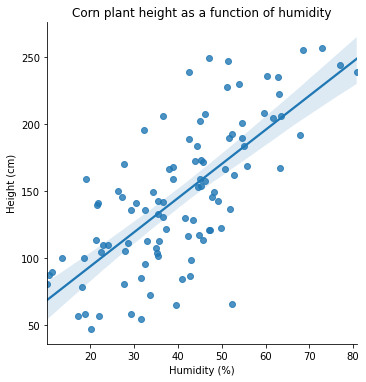

In [5]:
sns.lmplot(data=corn, x='humid', y='height')
plt.xlabel('Humidity (%)')
plt.ylabel('Height (cm)')
plt.title('Corn plant height as a function of humidity');

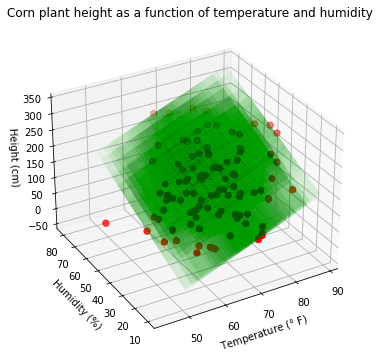

In [6]:
ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
ax.scatter(corn['temp'], corn['humid'], corn['height'],
           depthshade=True, s=40, color='#ff0000')
# create x,y
xx, yy = np.meshgrid(corn['temp'], corn['humid'])

# calculate corresponding z
z = 4.3825 * xx + 2.4693 * yy - 255.5434

# plot the surface
ax.plot_surface(xx, yy, z, alpha=0.01, color='#00ff00')

ax.view_init(30, azim=240)
ax.set_xlabel('Temperature ($\degree$ F)')
ax.set_ylabel('Humidity (%)')
ax.set_zlabel('Height (cm)')
plt.title('Corn plant height as a function of temperature and humidity');

One risk we run when adding more predictors to a model is that their correlations with the target may be nearly *collinear* with each other. This can make it difficult to determine which predictor is doing the heavy lifting. We shall explore this theme of **multicollinearity** in more depth in due course.

# Dealing with Categorical Variables

One issue we'd like to resolve is what to do with categorical variables, i.e. variables that represent categories rather than continua. In a Pandas DataFrame, these columns may well have strings or objects for values, but they need not. A certain heart-disease dataset from Kaggle, for example, has a target variable that takes values 0-4, each representing a different stage of heart disease.

## Dummying

One very effective way of dealing with categorical variables is to dummy them out. What this involves is making a new column for _each categorical value in the column we're dummying out_.

These new columns will be filled only with 0's and 1's, a 1 representing the presence of the relevant categorical value.

Let's look at a simple example:

In [7]:
comma_use = pd.read_csv('data/comma-survey.csv')

For more on this dataset see [here](https://fivethirtyeight.com/features/elitist-superfluous-or-popular-we-polled-americans-on-the-oxford-comma/).

In [8]:
comma_use.head()

,RespondentID,"In your opinion, which sentence is more gramatically correct?","Prior to reading about it above, had you heard of the serial (or Oxford) comma?","How much, if at all, do you care about the use (or lack thereof) of the serial (or Oxford) comma in grammar?",How would you write the following sentence?,"When faced with using the word ""data"", have you ever spent time considering if the word was a singular or plural noun?","How much, if at all, do you care about the debate over the use of the word ""data"" as a singluar or plural noun?","In your opinion, how important or unimportant is proper use of grammar?",Gender,Age,Household Income,Education,Location (Census Region)
0,3292953864,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",No,Not much,Somewhat important,Male,30-44,"$50,000 - $99,999",Bachelor degree,South Atlantic
1,3292950324,"It's important for a person to be honest, kind...",No,Not much,"Some experts say it's important to drink milk,...",No,Not much,Somewhat unimportant,Male,30-44,"$50,000 - $99,999",Graduate degree,Mountain
2,3292942669,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",Yes,Not at all,Very important,Male,30-44,NaN,NaN,East North Central
3,3292932796,"It's important for a person to be honest, kind...",Yes,Some,"Some experts say it's important to drink milk,...",No,Some,Somewhat important,Male,18-29,NaN,Less than high school degree,Middle Atlantic
4,3292932522,"It's important for a person to be honest, kind...",No,Not much,"Some experts say it's important to drink milk,...",No,Not much,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
comma_use['In your opinion, which sentence is more gramatically correct?'].value_counts()

It's important for a person to be honest, kind, and loyal.    641
It's important for a person to be honest, kind and loyal.     488
Name: In your opinion, which sentence is more gramatically correct?, dtype: int64

In [10]:
comma_use.shape

(1129, 13)

In [11]:
comma_use.isna().sum().sum()

924

In [12]:
comma_use.dropna(inplace=True)

In [13]:
comma_use.shape

(825, 13)

In [14]:
# Let's try using sklearn's OneHotEncoder to create our dummy columns:

ohe = OneHotEncoder(drop='first')
comma_trans = ohe.fit_transform(comma_use.drop('RespondentID', axis=1))

Could we have used ```pd.get_dummies()``` instead?

Well, yes. And in fact ```get_dummies()``` is in some ways easier; for one thing, it's built right into Pandas. But there are drawbacks with it as well. The main advantage of the `sklearn` tool is that it stores information about the columns and creates a persistent function that can be used on future data of the same form. See [this page](https://stackoverflow.com/questions/36631163/pandas-get-dummies-vs-sklearns-onehotencoder-what-are-the-pros-and-cons) for more.

In [15]:
pd.get_dummies(comma_use.drop('RespondentID', axis=1))

,"In your opinion, which sentence is more gramatically correct?_It's important for a person to be honest, kind and loyal.","In your opinion, which sentence is more gramatically correct?_It's important for a person to be honest, kind, and loyal.","Prior to reading about it above, had you heard of the serial (or Oxford) comma?_No","Prior to reading about it above, had you heard of the serial (or Oxford) comma?_Yes","How much, if at all, do you care about the use (or lack thereof) of the serial (or Oxford) comma in grammar?_A lot","How much, if at all, do you care about the use (or lack thereof) of the serial (or Oxford) comma in grammar?_Not at all","How much, if at all, do you care about the use (or lack thereof) of the serial (or Oxford) comma in grammar?_Not much","How much, if at all, do you care about the use (or lack thereof) of the serial (or Oxford) comma in grammar?_Some","How would you write the following sentence?_Some experts say it's important to drink milk, but the data are inconclusive.","How would you write the following sentence?_Some experts say it's important to drink milk, but the data is inconclusive.",...,Education_Some college or Associate degree,Location (Census Region)_East North Central,Location (Census Region)_East South Central,Location (Census Region)_Middle Atlantic,Location (Census Region)_Mountain,Location (Census Region)_New England,Location (Census Region)_Pacific,Location (Census Region)_South Atlantic,Location (Census Region)_West North Central,Location (Census Region)_West South Central
0,1,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,0,1,1,0,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
6,0,1,0,1,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
7,0,1,0,1,1,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,0,1,0,1,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1125,1,0,1,0,0,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
1126,0,1,0,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1127,1,0,0,1,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


So what did the encoder do?

In [16]:
comma_trans

<825x34 sparse matrix of type '<class 'numpy.float64'>'
	with 7174 stored elements in Compressed Sparse Row format>

In [17]:
comma_trans.todense()

matrix([[0., 1., 0., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]])

In [18]:
ohe.get_feature_names()

array(["x0_It's important for a person to be honest, kind, and loyal.",
       'x1_Yes', 'x2_Not at all', 'x2_Not much', 'x2_Some',
       "x3_Some experts say it's important to drink milk, but the data is inconclusive.",
       'x4_Yes', 'x5_Not at all', 'x5_Not much', 'x5_Some',
       'x6_Somewhat important', 'x6_Somewhat unimportant',
       'x6_Very important', 'x6_Very unimportant', 'x7_Male', 'x8_30-44',
       'x8_45-60', 'x8_> 60', 'x9_$100,000 - $149,999', 'x9_$150,000+',
       'x9_$25,000 - $49,999', 'x9_$50,000 - $99,999',
       'x10_Graduate degree', 'x10_High school degree',
       'x10_Less than high school degree',
       'x10_Some college or Associate degree', 'x11_East South Central',
       'x11_Middle Atlantic', 'x11_Mountain', 'x11_New England',
       'x11_Pacific', 'x11_South Atlantic', 'x11_West North Central',
       'x11_West South Central'], dtype=object)

In [19]:
comma_df = pd.DataFrame(comma_trans.todense(), columns=ohe.get_feature_names())
comma_df.head()

,"x0_It's important for a person to be honest, kind, and loyal.",x1_Yes,x2_Not at all,x2_Not much,x2_Some,"x3_Some experts say it's important to drink milk, but the data is inconclusive.",x4_Yes,x5_Not at all,x5_Not much,x5_Some,...,x10_Less than high school degree,x10_Some college or Associate degree,x11_East South Central,x11_Middle Atlantic,x11_Mountain,x11_New England,x11_Pacific,x11_South Atlantic,x11_West North Central,x11_West South Central
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Multiple Regression in `statsmodels`

Let's build a multiple regression with `statsmodels`. Let's start with a toy model:

In [20]:
centers = np.arange(1, 6)
preds = np.array([stats.norm(loc=center, scale=3).rvs(200) for center in centers]).T
preds_df = pd.DataFrame(preds, columns=[f'var{center}' for center in centers])

target = preds_df['var1'] + 2*preds_df['var2'] + 3*preds_df['var3']\
    + 4*preds_df['var4'] + 5*preds_df['var5']
target_df = pd.DataFrame(target, columns=['target'])

In [21]:
df = pd.concat([preds_df, target_df], axis=1)

df.head()

,var1,var2,var3,var4,var5,target
0,4.079865,1.518236,-1.017688,2.165329,1.782980,21.639487
1,-1.596493,4.022722,4.839126,-1.271493,-1.456492,8.597896
2,0.522634,-1.189691,4.469110,6.841618,6.504503,71.439570
3,1.721851,5.021491,10.559791,3.977060,2.505305,71.878967
4,5.742278,4.676718,0.585747,9.192358,3.132841,69.286594


In [22]:
X = df.drop('target', axis=1)
y = df['target']

In [23]:
model = sm.OLS(endog=y, exog=X).fit()

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.768e+32
Date:                Tue, 13 Apr 2021   Prob (F-statistic):                        0.00
Time:                        08:29:01   Log-Likelihood:                          5958.5
No. Observations:                 200   AIC:                                 -1.191e+04
Df Residuals:                     195   BIC:                                 -1.189e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
var1           1.0000   7.11e-16   1.41e+15      0.000       1.000       1.000
var2           2.0000   6.62e-16   3.02e+15      0.000       2.000       2.000
var3           3.0000   6.08e-16   4.93e+15      0.000       3.000       3.000
var4           4.0000    5.9e-16   6.78e+15      0.000       4.000       4.000
var5           5.0000   5.62e-16    8.9e+15      0.000       5.000       5.000
==============================================================================
Omnibus:                        1.172   Durbin-Watson:                   0.608
Prob(Omnibus):                  0.557   Jarque-Bera (JB):                1.265
Skew:                          -0.171   Prob(JB):                        0.531
Kurtosis:                       2.814   Cond. No.                         3.01
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Diamonds Dataset

In [25]:
data = sns.load_dataset('diamonds').drop(['cut', 'color', 'clarity'], axis = 1)

In [26]:
data.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [27]:
X, y = data.drop('price', axis=1), data['price']

In [28]:
model2 = sm.OLS(y, X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.926
Method:                 Least Squares   F-statistic:                          1.120e+05
Date:                Tue, 13 Apr 2021   Prob (F-statistic):                        0.00
Time:                        08:29:01   Log-Likelihood:                     -4.7196e+05
No. Observations:               53940   AIC:                                  9.439e+05
Df Residuals:                   53934   BIC:                                  9.440e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
carat       9533.9516     59.317    160.730      0.000    9417.691    9650.213
depth         28.2911      2.416     11.712      0.000      23.556      33.026
table        -18.8220      2.558     -7.358      0.000     -23.836     -13.808
x           -522.6300     40.351    -12.952      0.000    -601.718    -443.542
y            182.3295     25.907      7.038      0.000     131.552     233.107
z           -676.7502     42.361    -15.976      0.000    -759.778    -593.722
==============================================================================
Omnibus:                    14555.339   Durbin-Watson:                   1.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           287131.956
Skew:                           0.809   Prob(JB):                         0.00
Kurtosis:                      14.186   Cond. No.                         829.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

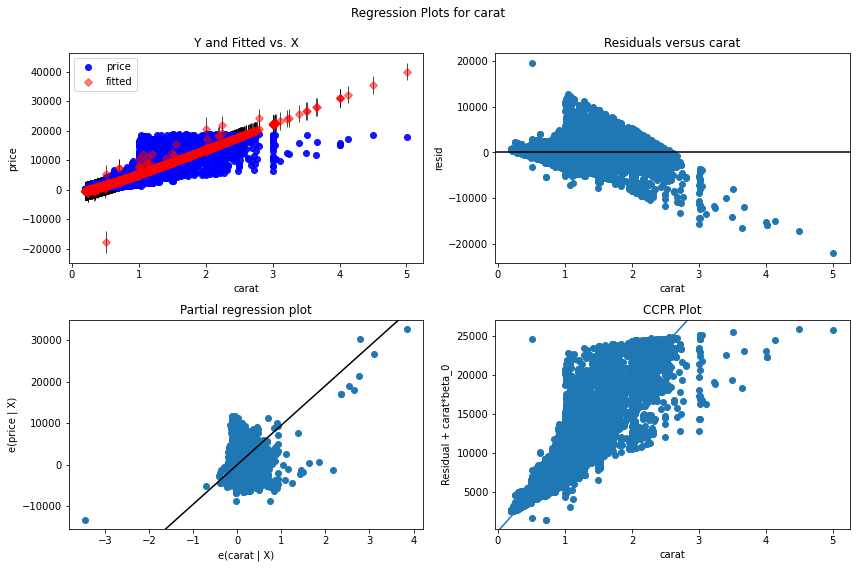

In [29]:
sm.graphics.plot_regress_exog(model2, 'carat', fig=plt.figure(figsize=(12, 8)));

### Check distribution of target

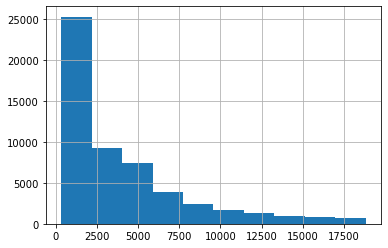

In [30]:
y.hist();

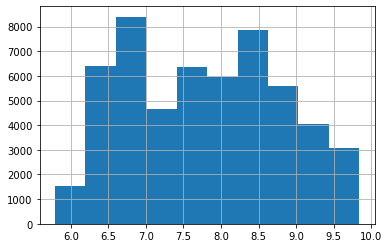

In [31]:
y_scld = np.log(y)
y_scld.hist();

### Build model with log-scaled target

In [32]:
model3 = sm.OLS(y_scld, X).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          7.072e+06
Date:                Tue, 13 Apr 2021   Prob (F-statistic):                        0.00
Time:                        08:29:04   Log-Likelihood:                         -7833.4
No. Observations:               53940   AIC:                                  1.568e+04
Df Residuals:                   53934   BIC:                                  1.573e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
carat         -0.7522      0.011    -69.197      0.000      -0.774      -0.731
depth          0.0319      0.000     72.131      0.000       0.031       0.033
table         -0.0062      0.000    -13.212      0.000      -0.007      -0.005
x              1.1098      0.007    150.072      0.000       1.095       1.124
y              0.0506      0.005     10.660      0.000       0.041       0.060
z              0.0340      0.008      4.377      0.000       0.019       0.049
==============================================================================
Omnibus:                    50951.621   Durbin-Watson:                   1.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28055158.482
Skew:                           3.704   Prob(JB):                         0.00
Kurtosis:                     114.481   Cond. No.                         829.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

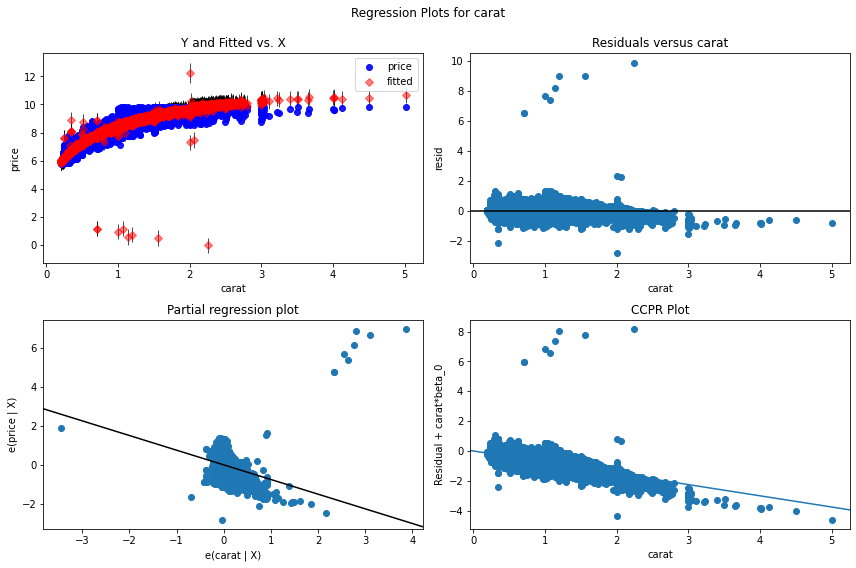

In [33]:
sm.graphics.plot_regress_exog(model3, 'carat', fig=plt.figure(figsize=(12, 8)));

**Remember that $R^2$ can be negative!**

In [34]:
bad_pred = np.mean(y) * np.ones(len(y))
worse_pred = (np.mean(y) + 1000) * np.ones(len(y))

print(metrics.r2_score(y, bad_pred))
print(metrics.r2_score(y, worse_pred))

0.0
-0.06283248452205892


# Putting it in Practice: Wine Dataset 🍷

## The Wine Dataset

This dataset includes measurable attributes of different wines as well as their rated quality.

In [ ]:
wine = pd.read_csv('data/wine.csv')

wine.head()

In [ ]:
wine.info()

In [ ]:
wine.describe()

Imagine we want to attempt to estimate the perceived quality of a wine using these attributes.

In [ ]:
wine['quality'].value_counts()

In [ ]:
wine['red_wine'].value_counts()

### 🧠 **Knowledge Check**

> Why are we using "quality" as the dependent variable (target)? Would it make }sense for another feature to be the target instead?

### Running the Regression

First, we'll separate the data into our predictors (X) and target (y)

In [ ]:
wine_preds = wine.drop('quality', axis=1)
wine_target = wine['quality']
wine_preds.head()

Now we can perform our (multiple) linear regression! Since we already used `statsmodels`, let's use that again to fit the model and then check the summary:

In [ ]:
# use sm.add_constant() to add constant term/y-intercept
predictors = sm.add_constant(wine_preds)
predictors

In [ ]:
model = sm.OLS(wine_target, predictors).fit()

> Alright! So we fitted our model! Take a look at the summary and look if you can understand the different parts.

In [ ]:
model.summary()

# Scaling

Before we construct a linear regression, let's *scale* our columns as z-scores. Why?

In a word, it's useful to have all of our variables be on the same scale, so that the resulting coefficients are easier to interpret. If the scales of the variables are very different one from another, then some of the coefficients may end up on very large or very tiny scales.

For more on this, see [this post](https://stats.stackexchange.com/questions/32649/some-of-my-predictors-are-on-very-different-scales-do-i-need-to-transform-them).

Let's try a model with our wine dataset now.

In [ ]:
# We'll include all the columns for now.

wine_preds_scaled = (wine_preds - np.mean(wine_preds)) / np.std(wine_preds)

In [ ]:
wine_preds_scaled.describe()

In [ ]:
predictors = sm.add_constant(wine_preds_scaled)
model = sm.OLS(wine_target, predictors).fit()
model.summary()

# Multiple Regression in Scikit-Learn

In [ ]:
# Let's create a StandardScaler object to scale our data for us.
ss = StandardScaler()


# Now we'll apply it to our data by using the .fit() and .transform() methods.

ss.fit(wine_preds)

wine_preds_st_scaled = ss.transform(wine_preds)

In [ ]:
# Check that the scaling worked about the same as when we did it by hand

np.allclose(wine_preds_st_scaled, wine_preds_scaled)

In [ ]:
wine_preds_scaled.head()

In [ ]:
wine_preds_st_scaled[:5, :]

In [ ]:
# Now we can fit a LinearRegression object to our training data!

lr = LinearRegression()
lr.fit(wine_preds_st_scaled, wine_target)

In [ ]:
# We can use the .coef_ attribute to recover the results
# of the regression.

lr.coef_

In [ ]:
lr.intercept_

In [ ]:
lr.score(wine_preds_st_scaled, wine_target)

In [ ]:
lr.predict(wine_preds_st_scaled)

## Sklearn Metrics

The metrics module in sklearn has a number of metrics that we can use to measure the accuracy of our model, including the $R^2$ score, the mean absolute error and the mean squared error. Note that the default 'score' on our model object is the $R^2$ score. Let's go back to our wine dataset:

In [ ]:
metrics.r2_score(wine_target, lr.predict(wine_preds_st_scaled))

Let's make sure this metric is properly calibrated. If we put simply $\bar{y}$ as our prediction, then we should get an $R^2$ score of *0*. And if we predict, say, $\bar{y} + 1$, then we should get a *negative* $R^2$ score.

In [ ]:
avg_quality = np.mean(wine_target)
num = len(wine_target)

metrics.r2_score(wine_target, avg_quality * np.ones(num))

In [ ]:
metrics.r2_score(wine_target, (avg_quality + 1) * np.ones(num))

In [ ]:
metrics.mean_absolute_error(wine_target, lr.predict(wine_preds_st_scaled))

In [ ]:
metrics.mean_squared_error(wine_target, lr.predict(wine_preds_st_scaled))

# Level Up: Regression with Categorical Features with the Comma Dataset

In [ ]:
comma_df.columns

In [ ]:
# We'll try to predict the first column of df: the extent to which
# the person accepts the sentence
# without the Oxford comma as more grammatically correct.

comma_target = comma_df['x0_It\'s important for a person to be honest, kind, and loyal.']

comma_predictors = comma_df[['x8_30-44',
       'x8_45-60', 'x8_> 60', 'x9_$100,000 - $149,999',
       'x9_$150,000+', 'x9_$25,000 - $49,999', 'x9_$50,000 - $99,999']]

comma_lr = LinearRegression()

comma_lr.fit(comma_predictors, comma_target)

In [ ]:
comma_lr.score(comma_predictors, comma_target)

In [ ]:
comma_lr.coef_

In [ ]:
comma_df.corr()['x0_It\'s important for a person to be honest, kind, and loyal.']

For more on the interpretation of regression coefficients for categorical variables, see [Erin's repo](https://github.com/hoffm386/coefficients-of-dropped-categorical-variables).